In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [4]:
water_data = pd.read_csv('data/water_potability.zip')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
# В данных есть пропуски. Выведем информацию о них в процентном соотношении:

display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [6]:
# Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

#Убедимся в отсутствии пропусков:

display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

In [7]:
# Теперь проблема пропусков устранена. Давайте по традиции разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:

X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

In [8]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


In [8]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


In [9]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [10]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


## KFold

Основные параметры инициализатора KFold:

n_split — число фолдов (число  из метода k-fold). По умолчанию — 5.

shuffle — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.

random_state — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

In [11]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [12]:
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


In [13]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))
 

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Основные параметры функции cross_validate():

estimator — модель, качество которой будет проверяться на кросс-валидации.<br>
X — матрица наблюдений.<br>
y — вектор-столбец правильных ответов.<br>
cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.<br>
scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).<br>
return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученные на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

In [14]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.02307987, 0.02301431, 0.02201557, 0.02008033, 0.02005744]),
 'score_time': array([0.00199842, 0.0019989 , 0.00197983, 0.0010016 , 0.00191951]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [15]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.81
## Valid k-fold mean accuracy: 0.74

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


## LEAVE-ONE-OUT

In [16]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.95
## Valid k-fold mean accuracy: 0.90

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


Примечание. Метод leave-one-out можно реализовать и без использования специального класса — достаточно просто указать параметр n_split=n в инициализаторе KFold, где n — количество строк в таблице.

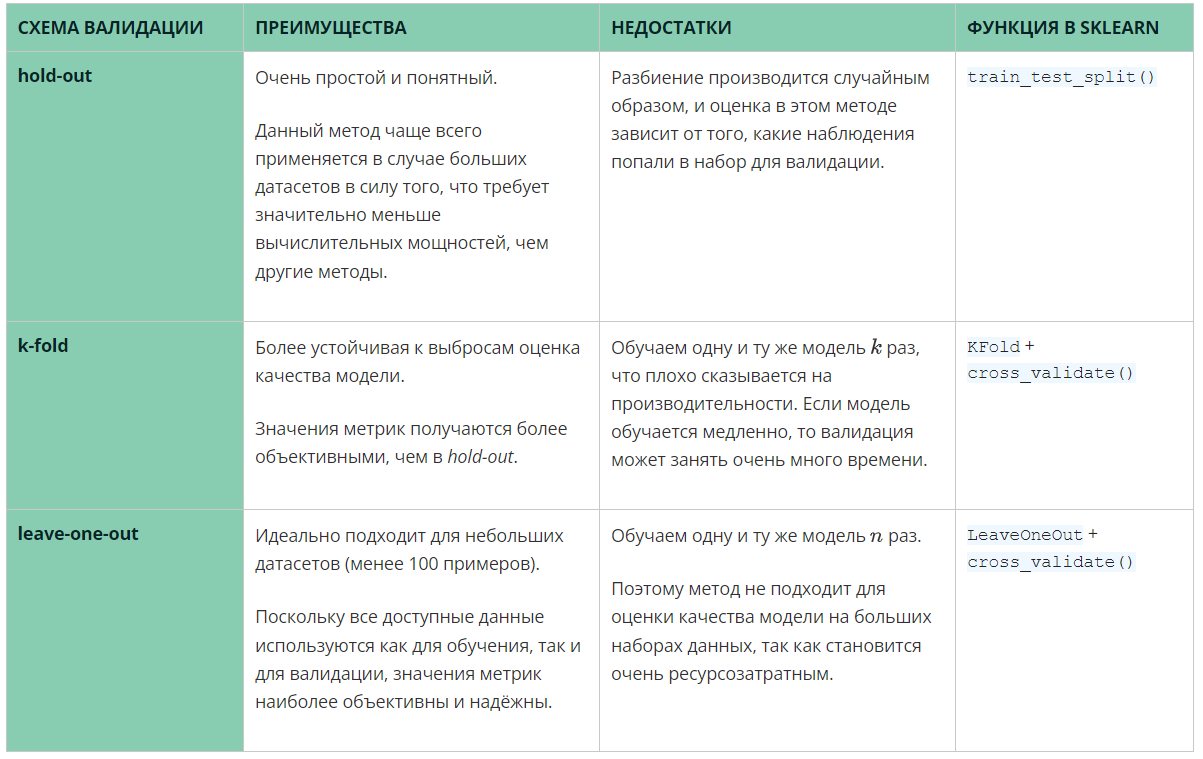

## Стратифицированное разбиение


In [17]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


In [18]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


In [19]:
# для кросс-валидации

skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


## ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

In [20]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



## Взвешивание


In [21]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



## ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

<b>PR-кривая (precision-recall curve) — это график зависимости precision от recall при различных значениях порога вероятности.</b>

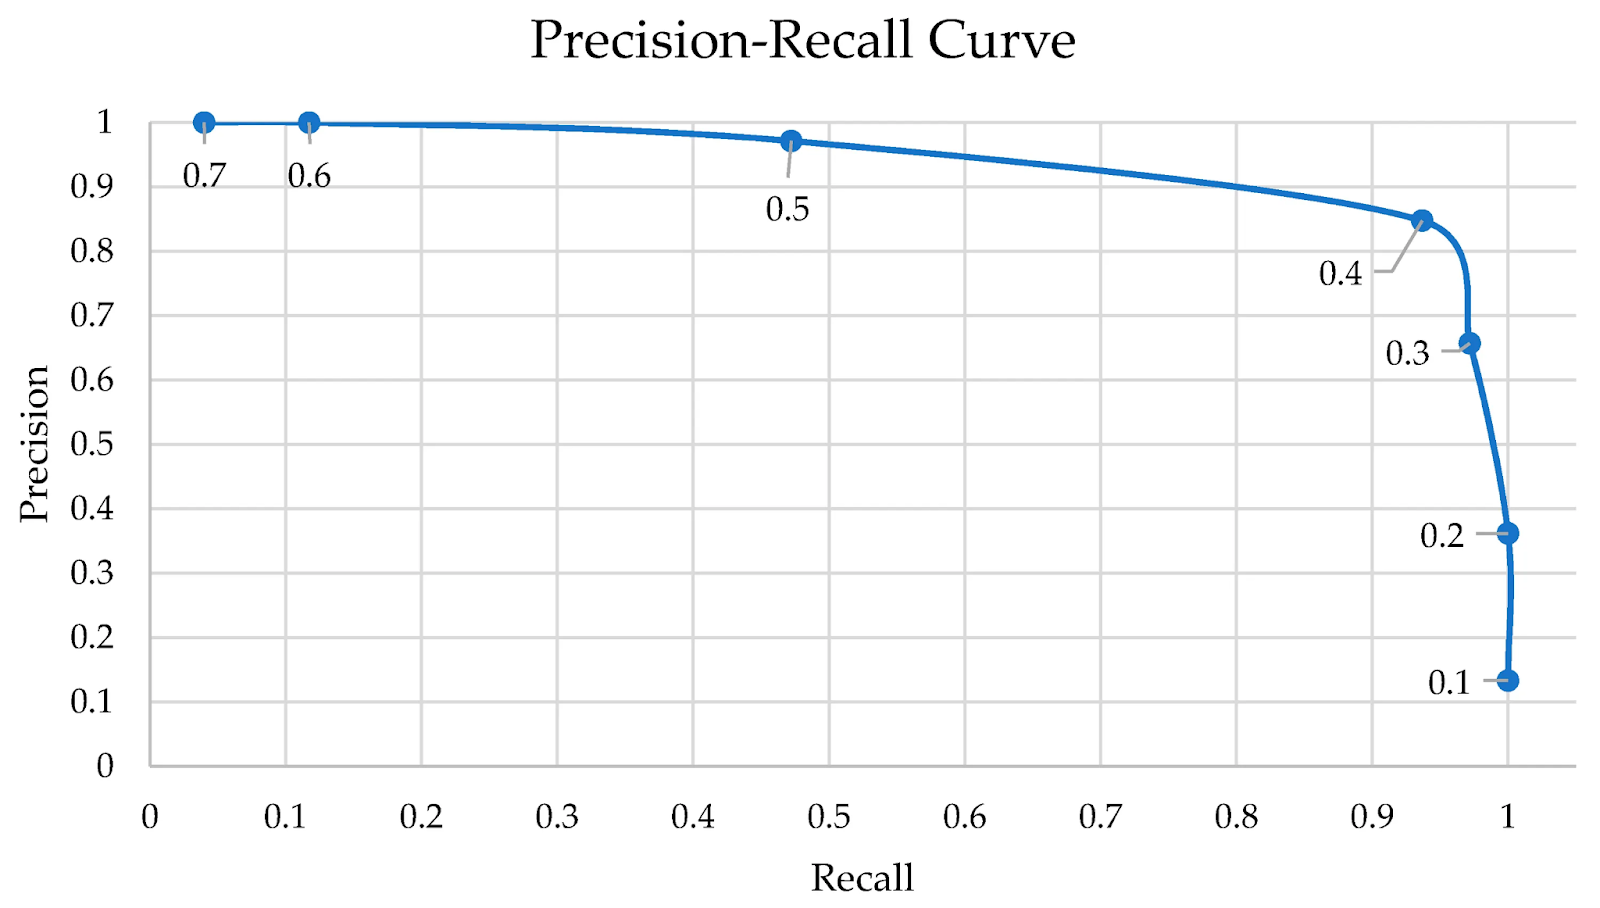

По площади под PR-кривой мы можем сравнивать модели между собой.

Подберём порог вероятности с помощью PR-кривой для нашего примера. Так как порог вероятности является внешним параметром модели, будет правильнее подбирать его на кросс-валидации, организованной на тренировочном наборе данных, а итоговое качество оценивать на отложенной выборке.

Перед построением PR-кривой нам необходимо предсказать вероятность принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate().

In [22]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [23]:
y_cv_proba_pred

array([[0.        , 1.        ],
       [0.24561404, 0.75438596],
       [1.        , 0.        ],
       ...,
       [0.60621762, 0.39378238],
       [1.        , 0.        ],
       [0.03030303, 0.96969697]])

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [24]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [25]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Осталось дело за малым. Вычислим значение -score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

Далее построим PR-кривую и отметим на ней точку максимума F$_1_$-score.

Best threshold = 0.33, F1-Score = 0.69


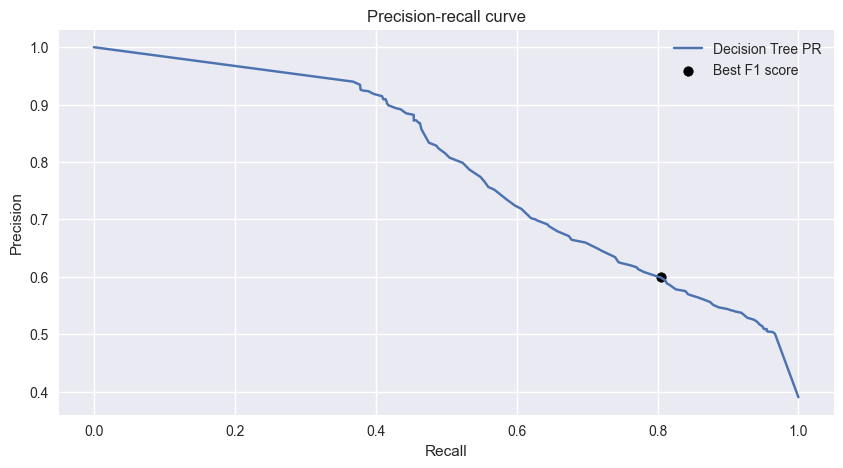

In [26]:
#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

Итак, согласно нашим вычислениям и построенной PR-кривой, максимум  (0.69) на кросс-валидации наблюдается при пороге вероятности 0.33.

Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [27]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.33
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



Примечание. Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn. В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

In [28]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.79


## СЭМПЛИРОВАНИЕ

In [30]:
#!pip install imbalanced-learn

In [31]:
from imblearn.over_sampling import SMOTE

In [32]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    1598
1    1022
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    1598
1    1598
Name: Potability, dtype: int64


In [33]:
# Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке 
# (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



## КРИВАЯ ОБУЧЕНИЯ


In [9]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, #генератор случайных чисел 
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, #модель
    X = X, #матрица наблюдений X
    y = y, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1' #метрика
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 262  851 1441 2030 2620]
Train scores: 
 [[0.8        0.72727273 0.72727273 0.72727273 0.72727273]
 [0.76156584 0.82522523 0.8757764  0.8757764  0.8757764 ]
 [0.78546099 0.80108011 0.78497653 0.78183613 0.78183613]
 [0.75440806 0.74526573 0.72822528 0.76443265 0.75997384]
 [0.73336393 0.75992939 0.72322275 0.74051593 0.76085963]]
Valid scores: 
 [[0.62222222 0.2228739  0.18128655 0.25329815 0.28486647]
 [0.64528302 0.4978903  0.46031746 0.53831776 0.56928839]
 [0.59622642 0.60687023 0.60805861 0.56624319 0.60820896]
 [0.60903733 0.68641115 0.63859649 0.59344894 0.67407407]
 [0.61981982 0.6797153  0.66294227 0.61689587 0.71719039]]


In [10]:
# Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать среднее по столбцам матриц train_scores и valid_scores:

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.74181818 0.84282405 0.78703798 0.75046111 0.74357833]
Valid k-fold f1 scores [0.31290946 0.54221938 0.59712148 0.6403136  0.65931273]


Теперь можно построить графики кривых обучения:

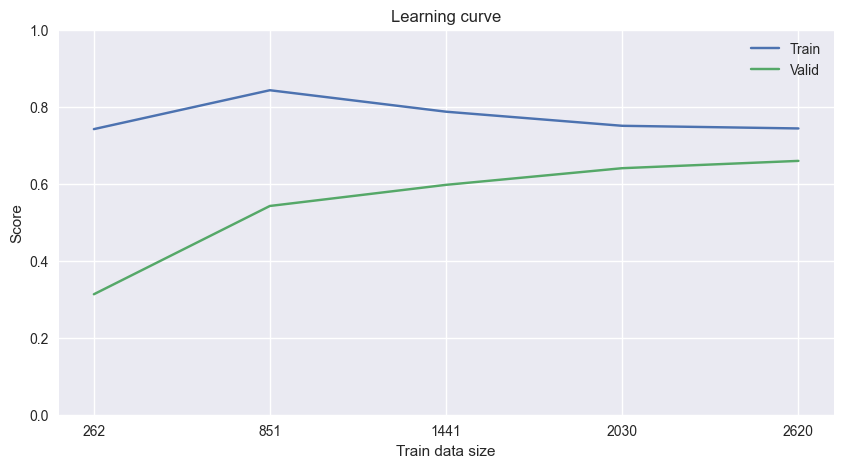

In [11]:
#Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

Видно, что в процессе увеличения количества наблюдений в обучающем наборе данных, метрики на тренировочной и валидационной выборках постепенно приближаются друг к другу, то есть уменьшается разброс (variance).

На финальном этапе, при использовании всех 2620 наблюдений из обучающей выборки, разница в показателях между тренировочной и валидационной выборками всё ещё присутствует, однако эту разницу можно принять как случайную.

Для удобства дальнейшего использования описанных выше действий для построения кривой обучения давайте обернём их в функцию plot_learning_curve(). У функции будет несколько аргументов: модель, набор данных (X, y), кросс-валидатор, метрика, координатная плоскость matplotlib, на которой будет строиться график, и подпись графика:

In [12]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

Теперь, когда у нас есть наша функция, давайте построим кривые обучения для нескольких моделей. Будем использовать следующие модели:

- логистическую регрессию,<br>
- дерево решений с ограниченной максимальной глубиной и количеством объектов в листе,<br>
- дерево решений без ограничений.<br>

Создадим список, в котором будем хранить эти модели:

In [13]:
#Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

Наконец, построим кривые обучения для каждой из моделей. Для этого заранее создадим k-fold-кросс-валидатор со стратификацией на пять фолдов. Создадим фигуру с тремя координатными плоскостями. Реализуем цикл по составленному списку из моделей и их индексам (они нам понадобятся для отображения на соответствующих координатных плоскостях). Внутри цикла будем вызывать нашу функцию plot_learning_curve():

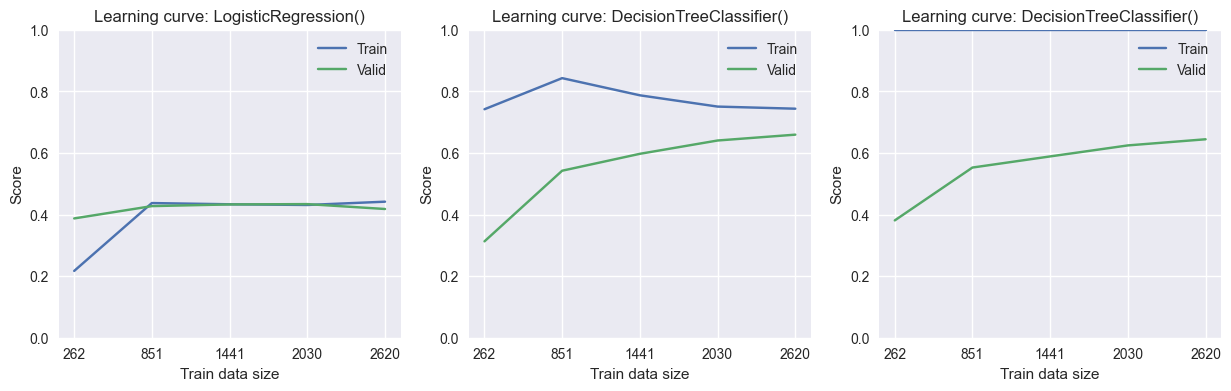

In [15]:
#Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X, y, # x_train, y_train
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)